In [1]:
#IMPORTS
import firebase_admin
from firebase_admin import firestore
from firebase_admin import credentials
import pandas as pd
from itables import show



In [2]:
cred = credentials.Certificate("./brazillian-gastronomic-tour-firebase-adminsdk-ojrgu-1c98d6e4b6.json")
app = firebase_admin.initialize_app(cred)

db = firestore.client()

In [3]:
def collection_to_df(collection):
    items = list(db.collection(collection).stream())
    items_dict = list(map(lambda x: {'id': x.id, **x.to_dict()}, items))
    return pd.DataFrame(items_dict)
    

# Inicializando dataframes

In [4]:
#Initialize Dataframes

users_df = collection_to_df("users")
users_df = users_df.rename(columns={"gameLevel": "currentGameLevel"})
users_df = users_df.rename(columns={"id": "user"})
users_df = users_df.set_index("user")

# REMOVE Gilberto e Caio
users_df = users_df.drop(index = "GyaYyj1DPDQCFL8dtFJeLUbnqsr2").drop(index = "LrXx1XUUAfT05eBhi37WwrUF33e2")


user_level_df = collection_to_df("userLevel")

a_questions_df = collection_to_df("answeredQuestions")
a_questions_df['question'] = a_questions_df['question'].astype(int)
a_questions_df = a_questions_df.drop(columns=["correctAnswer", "id"])
questions_df = collection_to_df("questions")
questions_df = questions_df.rename(columns={"id": "question"})
questions_df['question'] = questions_df['question'].astype(int)

a_questions_df['lastUpdated']  = pd.to_datetime(a_questions_df.lastUpdated)
a_questions_df = questions_df.merge(a_questions_df, how="inner", on="question")
a_questions_df = a_questions_df.merge(users_df, how="inner", on="user")

a_questions_df = a_questions_df.sort_values("lastUpdated", ascending=True)

user_level_df = user_level_df.merge(users_df, how="inner", on="user")

#users_df


# Notas
### Relação de notas dos jogadores por fase prática e de domínio

In [5]:

#user_nota

user_nota = a_questions_df.query("attemptNumber == 1").groupby(["user", "lagunasPhase", "ageRange", "gender", "correct"], as_index=False)["question"].count()

user_nota = user_nota.pivot_table(index=["user","ageRange", "gender", "lagunasPhase"], 
                    columns=["correct"], 
                    values='question',
                    fill_value=0, 
                    aggfunc='sum').reset_index()


# 4 = coluna True
# 3 = coluna False



user_nota["nota"] = (user_nota.iloc[:,5] / (user_nota.iloc[:,5] + user_nota.iloc[:,4])) * 10


#user_nota.head(2)


### Relação de notas dos jogadores por fase prática e de domínio e level

In [6]:
#user_nota_level

user_nota_level = a_questions_df.query("attemptNumber == 1").groupby(["user", "level", "lagunasPhase", "ageRange", "gender", "correct"], as_index=False)["question"].count()

user_nota_level = user_nota_level.pivot_table(index=["user", "ageRange", "gender", "level", "lagunasPhase"], 
                    columns=["correct"], 
                    values='question',
                    fill_value=0, 
                    aggfunc='sum').reset_index()

user_nota_level["nota"] = (user_nota_level.iloc[:,6] / (user_nota_level.iloc[:,6] + user_nota_level.iloc[:,5])) * 10

#user_nota_level.head(6)

#user_nota_level.query("user =='kElSsXoFsvN9lUupxzWAmJPJhbz1'")

### Média de nota por idade

#### Fase Prática

array([<Axes: title={'center': 'nota'}, xlabel='ageRange'>], dtype=object)

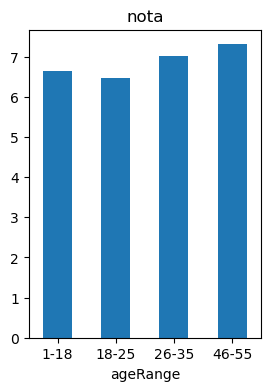

In [7]:
user_nota_level_average_age_range_practice = user_nota_level.query("lagunasPhase == 'practice'").groupby(["ageRange"])["nota"].mean()

user_nota_level_average_age_range_practice.plot.bar(subplots=True, figsize=(3,4), rot=0)


#### Fase Domínio

array([<Axes: title={'center': 'nota'}, xlabel='ageRange'>], dtype=object)

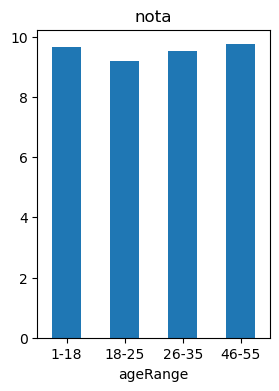

In [8]:
user_nota_level_average_age_range_domain = user_nota_level.query("lagunasPhase == 'domain'").groupby(["ageRange"])["nota"].mean()

user_nota_level_average_age_range_domain.plot.bar(subplots=True, figsize=(3,4), rot=0)

### Média de nota por lagunasPhase

array([<Axes: title={'center': 'nota'}, xlabel='lagunasPhase'>],
      dtype=object)

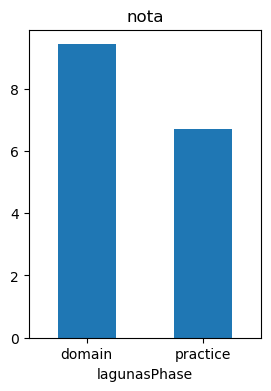

In [9]:
user_nota_level_average_lagunas = user_nota_level.groupby(["lagunasPhase"])["nota"].mean()

user_nota_level_average_lagunas.plot.bar(subplots=True, figsize=(3,4), rot=0)

### Média de nota por sexo

#### Fase Prática

array([<Axes: title={'center': 'nota'}, xlabel='gender'>], dtype=object)

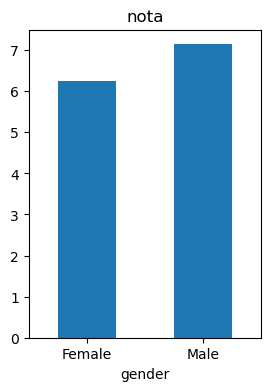

In [10]:
user_nota_level_average_gender_practice = user_nota_level.query("lagunasPhase == 'practice'").groupby(["gender"])["nota"].mean()

user_nota_level_average_gender_practice.plot.bar(subplots=True, figsize=(3,4), rot=0)

#### Fase de Domínio

array([<Axes: title={'center': 'nota'}, xlabel='gender'>], dtype=object)

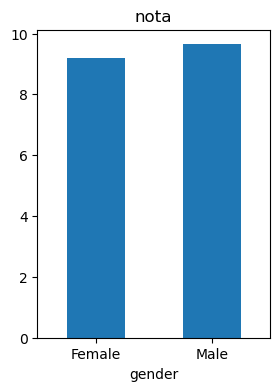

In [11]:
user_nota_level_average_gender_domain = user_nota_level.query("lagunasPhase == 'domain'").groupby(["gender"])["nota"].mean()

user_nota_level_average_gender_domain.plot.bar(subplots=True, figsize=(3,4), rot=0)

# Relação de acerto e erro

### Acerto e erro por nível

In [12]:
#acerto_erro_by_nivel

acerto_erro_by_nivel = a_questions_df.query("attemptNumber == 1").groupby(["level", "correct"], as_index=False).agg({'question': 'count'})

acerto_erro_by_nivel['percent'] =  acerto_erro_by_nivel['question'] / acerto_erro_by_nivel.groupby(['level'])['question'].transform('sum') * 100
show(acerto_erro_by_nivel)

### Acerto e erro por fase prática e de domínio

In [13]:
#acerto_erro_by_phase

acerto_erro_by_phase = a_questions_df.query("attemptNumber == 1").groupby(["lagunasPhase", "correct"], as_index=False).agg({'question': 'count'})


acerto_erro_by_phase['percent'] =  acerto_erro_by_phase['question'] / acerto_erro_by_phase.groupby(['lagunasPhase'])['question'].transform('sum') * 100
show(acerto_erro_by_phase)

### Acerto e erro por fase e nível

In [14]:
#Taxa de acerto e erro por nível e mostrando a fase laguna

acerto_erro_by_phase_level = a_questions_df.query("attemptNumber == 1").groupby(["level", "lagunasPhase", "correct"], as_index=False).agg({'question': 'count'})


acerto_erro_by_phase_level['percent'] =  acerto_erro_by_phase_level['question'] / acerto_erro_by_phase_level.groupby(['level'])['question'].transform('sum') * 100
show(acerto_erro_by_phase_level)

### Acerto e erro por faixa etária

In [15]:
acerto_erro_by_age_range = a_questions_df.query("attemptNumber == 1").groupby(["ageRange", "correct"], as_index=False).agg({'question': 'count'})
show(acerto_erro_by_age_range)


### Acerto e erro por gênero

In [16]:
acerto_erro_by_gender = a_questions_df.query("attemptNumber == 1").groupby(["gender", "correct"], as_index=False).agg({'question': 'count'})
show(acerto_erro_by_gender)

# Porcentagem de acerto e erro por questão

In [17]:
#questions_percentage

questions_percentage = a_questions_df.query("attemptNumber == 1").groupby(["question", "correct"], as_index=False)["text"].count().rename(columns={"text": "count"})


questions_percentage = questions_percentage.pivot_table(index=["question"], 
                    columns=["correct"], 
                    values='count',
                    fill_value=0, 
                    aggfunc='sum').reset_index()

questions_percentage.rename(columns={ questions_percentage.columns[2]: "corretas" }, inplace = True)
questions_percentage.rename(columns={ questions_percentage.columns[1]: "erradas" }, inplace = True)


questions_percentage["% corretas"] = (questions_percentage["corretas"] * 100 / (questions_percentage["corretas"] + questions_percentage["erradas"]))
questions_percentage["% erradas"] = (questions_percentage["erradas"] * 100 / (questions_percentage["corretas"] + questions_percentage["erradas"]))
questions_percentage["total de perguntas"] = questions_percentage["erradas"]  + questions_percentage["corretas"] 

show(questions_percentage)

# Classificação de perfis de acordo com a metodologia Serrano-Laguna

In [18]:
#Definição de perfis laguna
#IT = 6
#FT = 8


it = 7
ft = 7
# FA >= FT ==> 
def classifier(row):
    if row["domain"] >= ft:
            if row["practice"] < it:
                  return "learner"
            else:
                  return "master"
    else:
            if row["practice"] < it:
                  return "non-learner"
            else:
                  return "outlier"

user_nota_classification = user_nota.pivot(index=["user", "ageRange"], columns=["lagunasPhase"], values="nota")
user_nota_classification["classification"] = user_nota_classification.apply(classifier, axis=1)

#user_nota_classification.head(3)


### Gráfico com a clasificação geral

<Axes: ylabel='count'>

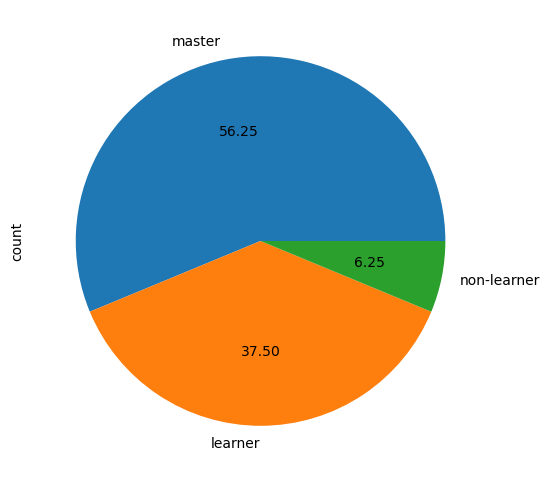

In [19]:
#Plot Grafico
user_nota_classification["classification"].value_counts().plot.pie(figsize=(6, 6), autopct="%.2f")

In [20]:
#user_nota_classification_level

user_nota_classification_level = user_nota_level.pivot(index=["user", "level"], columns="lagunasPhase", values="nota").reset_index()
user_nota_classification_level["classification"] =  user_nota_classification_level.apply(classifier, axis=1)
#user_nota_classification_level.head(9)

### Gráfico com a clasificação por nível

In [21]:
#user_nota_classification_level_reshaped

user_nota_classification_level_reshaped = user_nota_classification_level.drop(["domain", "practice"], axis=1)

user_nota_classification_level_reshaped = user_nota_classification_level_reshaped.groupby(["level", "classification"]).count().reset_index()

user_nota_classification_level_reshaped = pd.pivot_table(user_nota_classification_level_reshaped, index = "classification", columns="level", values="user", fill_value=0)

show(user_nota_classification_level_reshaped)



array([<Axes: ylabel='1'>, <Axes: ylabel='2'>, <Axes: ylabel='3'>],
      dtype=object)

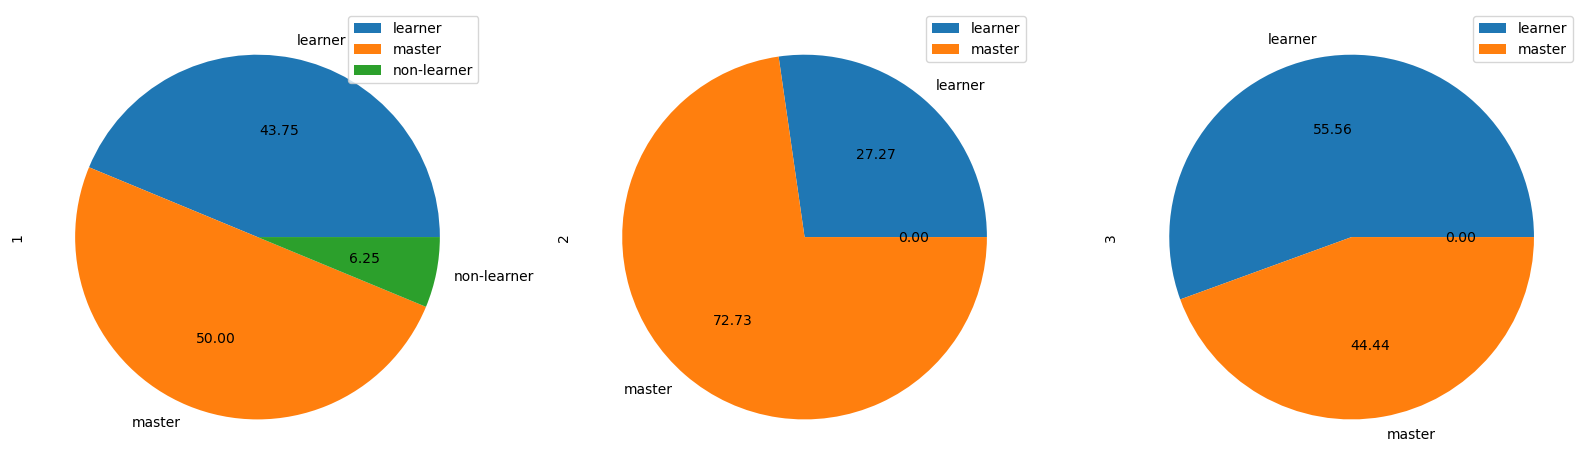

In [22]:
#Plot Grafico

user_nota_classification_level_reshaped.plot.pie(subplots=True,figsize=(20, 10), autopct="%.2f")

### Gráfico com a classificação por faixa etária

In [23]:
user_nota_classification_age_range = user_nota.pivot(index=["user",  "ageRange"], columns=["lagunasPhase"], values="nota").reset_index()
user_nota_classification_age_range["classification"] =  user_nota_classification_age_range.apply(classifier, axis=1)
user_nota_classification_age_range = user_nota_classification_age_range.drop(["domain", "practice"], axis=1)
user_nota_classification_age_range = user_nota_classification_age_range.groupby(["ageRange", "classification"]).count().reset_index()

user_nota_classification_age_range = pd.pivot_table(user_nota_classification_age_range, index = "classification", columns="ageRange", values="user", fill_value=0)
show(user_nota_classification_age_range)



array([<Axes: ylabel='1-18'>, <Axes: ylabel='18-25'>,
       <Axes: ylabel='26-35'>, <Axes: ylabel='46-55'>], dtype=object)

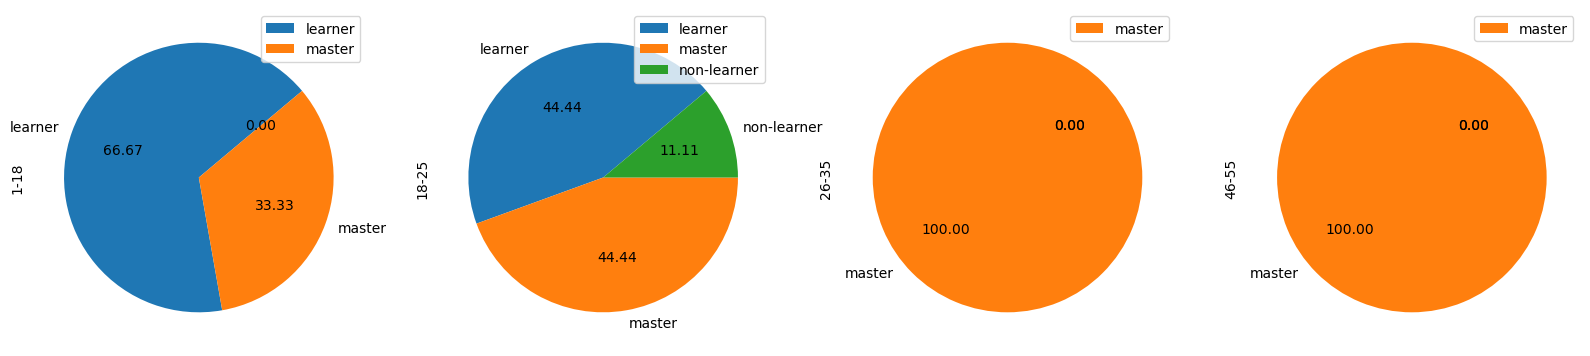

In [24]:
#user_nota_classification_age_range.plot.bar(subplots=True, figsize=(3, 10), rot=0)

user_nota_classification_age_range.plot.pie(subplots=True,figsize=(20, 8), autopct="%.2f", startangle=40)

### Relação por gênero

In [25]:
user_nota_classification_gender = user_nota.pivot(index=["user",  "gender"], columns=["lagunasPhase"], values="nota").reset_index()
user_nota_classification_gender["classification"] =  user_nota_classification_gender.apply(classifier, axis=1)
user_nota_classification_gender = user_nota_classification_gender.drop(["domain", "practice"], axis=1)
user_nota_classification_gender = user_nota_classification_gender.groupby(["gender", "classification"]).count().reset_index()

user_nota_classification_gender = pd.pivot_table(user_nota_classification_gender, index = "classification", columns="gender", values="user", fill_value=0)
show(user_nota_classification_gender)

### Relação de classificação no sexo Feminino

array([<Axes: ylabel='Female'>], dtype=object)

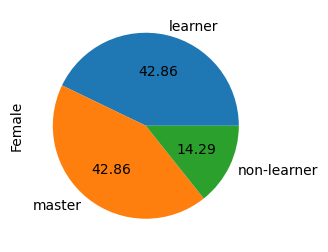

In [26]:
user_nota_classification_gender["Female"].plot.pie(subplots=True, figsize=(3, 10), autopct="%.2f")

### Relação de classificação no sexo Masculino

array([<Axes: ylabel='Male'>], dtype=object)

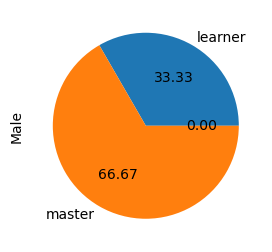

In [27]:
user_nota_classification_gender["Male"].plot.pie(subplots=True, figsize=(3, 10), autopct="%.2f")

# Relação de tempo entre perguntas

In [28]:
a_questions_df["averageSecondsBwQuestions"] = a_questions_df.groupby(['user', 'level', 'lagunasPhase'])['lastUpdated'].diff().dt.seconds


### Relação de tempo entre perguntas por nível e fase (prática/domínio)

In [29]:
a_questions_df_average_time_level = a_questions_df.groupby(['user', 'level', 'lagunasPhase'])["averageSecondsBwQuestions"].mean().reset_index()
#a_questions_df_average_time_level.head(6)

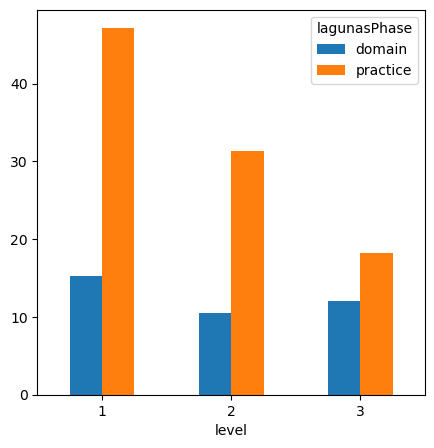

In [30]:
a_questions_df_average_time_level_general = pd.pivot_table(a_questions_df_average_time_level, index = "level", columns="lagunasPhase", values="averageSecondsBwQuestions", aggfunc="mean")
a_questions_df_average_time_level_general.plot.bar(figsize=(5, 5), rot=0)
show(a_questions_df_average_time_level_general)


### Média de tempo entre perguntas por fase (prática/domínio)

In [31]:
a_questions_df_average_time = a_questions_df_average_time_level.groupby(['user', 'lagunasPhase'])["averageSecondsBwQuestions"].mean().reset_index()
#a_questions_df_average_time.head(3)

<Axes: xlabel='lagunasPhase'>

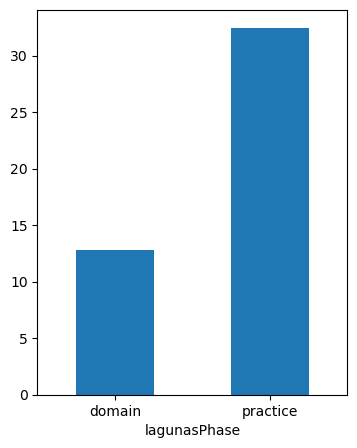

In [32]:
a_questions_df_average_time_general = a_questions_df_average_time.groupby("lagunasPhase")["averageSecondsBwQuestions"].mean()
a_questions_df_average_time_general.plot.bar(figsize=(4, 5), rot=0)
